In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [4]:
def find_valley_and_peak(signal, patient_id, dB, freq, vold_threshold=1, show_plot=False):
        
    # 1. Detect the first valley around 100 seconds (local minimum)
    valley_indices, _ = find_peaks(-signal, distance=20)  # Invert signal to detect valleys
    valley_times = time[valley_indices]
    valley_data = signal[valley_indices]

    # Logic to handle the valley correctly
    mask1 = valley_times >= 45
    mask2 = valley_times <= 150
    
    valley_times_masked = valley_times[(mask1) & (mask2)]
    valley_data_masked = valley_data[(mask1) & (mask2)]
    valley_indices_masked = valley_indices[(mask1) & (mask2)]
    
    arg_max = 0
    if len(valley_times_masked) == 1:
        first_valley_time = valley_times_masked[arg_max]
        first_valley_index = valley_indices_masked[arg_max]
        
    elif len(valley_times_masked) > 1:
        arg_max = np.argmax(-valley_data_masked)
        first_valley_time = valley_times_masked[arg_max]
        first_valley_index = valley_indices_masked[arg_max]
        
    elif len(valley_times_masked)==0:
        plt.plot(time, signal)
        # plt.plot(first_valley_time, signal[first_valley_index], 'ro', label='First Valley')
        # plt.plot(closest_peak_time, closest_peak_value, 'go', label='Highest Peak After Valley')
        # plt.legend()
        #print("No response")
        plt.title(f"{patient_id}_{dB}_no_response")
        plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
        plt.clf()
        return 0, 0

        # # Find the valley closest to 100 seconds
        # target_time = 100
        # valley_idx_closest = np.argmin(np.abs(valley_times - target_time))
        # first_valley_index = valley_indices[valley_idx_closest]
        # first_valley_time = time[first_valley_index]
    
    #print(f"First valley found at time: {first_valley_time:.2f} seconds")
    
    
    # 2. Detect the closest peak to the first valley
    # Limit the search to the portion of the signal after the first valley
    first_valley_index = np.where(time == first_valley_time)[0][0]
    #print(f"first_valley_index: {first_valley_index}")
          
    signal_after_valley = signal[first_valley_index:]
    time_after_valley = time[first_valley_index:]

    # Find all peaks after the valley
    peak_indices, _ = find_peaks(signal_after_valley)
    peak_times = time_after_valley[peak_indices]

    # Find the index of the peak closest to the valley time
    if len(peak_times)==0:
        print(f"patient_id: {patient_id}, dB: {dB}, No peaks detected")
        plt.plot(time, signal)
        plt.title(f"{patient_id}_{dB}_no_peaks")
        plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
        plt.clf()
        return 0, 0
    
    closest_peak_idx = np.argmin(np.abs(peak_times - first_valley_time))
    closest_peak_index = peak_indices[closest_peak_idx]
    closest_peak_value = signal_after_valley[closest_peak_index]
    closest_peak_time = time_after_valley[closest_peak_index]

    # 3. Are there any Shoulder Points?
    dy = np.gradient(signal_after_valley)
    shoulder_indices, _ = find_peaks(-dy)
    shoulder_times = time_after_valley[shoulder_indices]
    shoulder_values = signal_after_valley[shoulder_indices]
    
    mask = shoulder_times < closest_peak_time
    if sum(mask) > 0:
        
        masked_shoulder_times = shoulder_times[mask]
        masked_shoulder_values = shoulder_values[mask]
        
        if len(masked_shoulder_times)==1:
            
            print(f"patient_id: {patient_id}, dB: {dB}, 1 shoulder points detected")
            
            closest_peak_time = masked_shoulder_times[0]
            closest_peak_value = masked_shoulder_values[0]
            
            if closest_peak_time > 220:
                print(f"patient_id: {patient_id}, dB: {dB}, No peaks detected")
                plt.plot(time, signal)
                plt.title(f"{patient_id}_{dB}_no_peaks")
                plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
                plt.clf()
                return 0, 0

            # Plot signal with valley and peak marked
            plt.plot(time, signal)
            plt.plot(first_valley_time, signal[first_valley_index], 'ro', label='First Valley')
            plt.plot(closest_peak_time, closest_peak_value, 'go', label='Highest Peak After Valley')
            plt.legend()
            plt.title(f"{patient_id}_{dB}")
            plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
            plt.clf()
        
        else:
            print(f"patient_id: {patient_id}, dB: {dB}, more than 1 shoulder points detected")
            
            if closest_peak_time > 220:
                print(f"patient_id: {patient_id}, dB: {dB}, No peaks detected")
                plt.plot(time, signal)
                plt.title(f"{patient_id}_{dB}_no_peaks")
                plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
                plt.clf()
                return 0, 0
            
            closest_peak_time = shoulder_times[0]
            closest_peak_value = shoulder_values[0]
            
            # Plot signal with valley and peak marked
            plt.plot(time, signal)
            plt.plot(first_valley_time, signal[first_valley_index], 'ro', label='First Valley')
            plt.plot(closest_peak_time, closest_peak_value, 'go', label='Peak After Valley')
            #plt.scatter(shoulder_times, shoulder_values, label="shoulder points")
            plt.legend()
            plt.title(f"{patient_id}_{dB}")
            plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
            plt.clf()

    else:        
        # Plot signal with valley and peak marked
        plt.plot(time, signal)
        plt.plot(first_valley_time, signal[first_valley_index], 'ro', label='First Valley')
        plt.plot(closest_peak_time, closest_peak_value, 'go', label='Highest Peak After Valley')
        plt.legend()
        plt.title(f"{patient_id}_{dB}")
        plt.savefig(f"../processed_dataset_with_smoothing/labeled_images_{freq}/{patient_id}_{dB}.png")
        plt.clf()
    
    #print("After plot")
    return signal[first_valley_index], closest_peak_value

In [5]:
START_TIME = 0
END_TIME = 301
FREQUENCY = 2

cols = [str(i) for i in range(START_TIME, END_TIME, FREQUENCY)]
time = np.arange(START_TIME, END_TIME, FREQUENCY)

patient_id: A1_A1_ID-12, dB: 0dB, 1 shoulder points detected
patient_id: A1_A1_ID-12, dB: 40dB, 1 shoulder points detected
patient_id: A2_A2_ID-18, dB: 35dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 30dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 40dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 5dB, 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 30dB, 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 40dB, 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 60dB, 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 35dB, more than 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 5dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 40dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 60dB, 1 shoulder points detected
patient_id: A8_A8_ID-12, dB: 15dB, 1 shoulder points detected
patient_id: A9_A9_ID-19, dB: 15dB, 1 shoulder points detected
patient_id: A9_A9_ID-19, dB: 20dB, 1 shoulder points detected
p

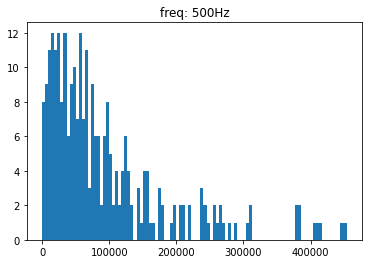

patient_id: A1_A1_ID-12, dB: 15dB, 1 shoulder points detected
patient_id: A1_A1_ID-12, dB: 40dB, 1 shoulder points detected
patient_id: A2_A2_ID-18, dB: 15dB, 1 shoulder points detected
patient_id: A2_A2_ID-18, dB: 5dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 0dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 20dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 60dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 35dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 5dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 15dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 60dB, 1 shoulder points detected
patient_id: A8_A8_ID-12, dB: 15dB, 1 shoulder points detected
patient_id: A9_A9_ID-19, dB: 0dB, 1 shoulder points detected
patient_id: A9_A9_ID-19, dB: 15dB, 1 shoulder points detected
patient_id: A10_A10_ID-10, dB: 15dB, 1 shoulder points detected
patient_id: A10_A10_ID-10, dB: 20dB, 1 shoulder points detected
patient_

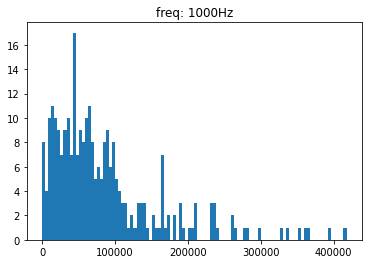

patient_id: A1_A1_ID-12, dB: 60dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 60dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 0dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 25 2dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 40dB, 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 25dB, more than 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 30dB, 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 60dB, more than 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 45dB, 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 60dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 60dB, 1 shoulder points detected
patient_id: A8_A8_ID-12, dB: 0dB, more than 1 shoulder points detected
patient_id: A8_A8_ID-12, dB: 20dB, 1 shoulder points detected
patient_id: A8_A8_ID-12, dB: 60dB, 1 shoulder points detected
patient_id: A9_A9_ID-18, dB: 35dB, more than 1 shoulder points detected
patient_id: A12_A12_ID-19, dB:

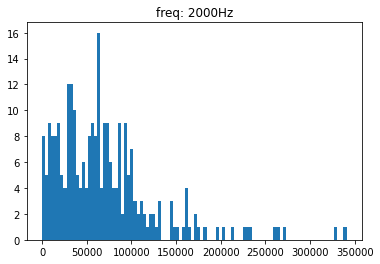

patient_id: A1_A1_ID-12, dB: 25dB, 1 shoulder points detected
patient_id: A1_A1_ID-12, dB: 60dB, 1 shoulder points detected
patient_id: A2_A2_ID-18, dB: 15dB, 1 shoulder points detected
patient_id: A2_A2_ID-18, dB: 20dB, 1 shoulder points detected
patient_id: A2_A2_ID-18, dB: 35dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 15dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 25dB, 1 shoulder points detected
patient_id: A3_A3_ID-17, dB: 60dB, 1 shoulder points detected
patient_id: A4_A4_ID-23, dB: 60dB, 1 shoulder points detected
patient_id: A5_A5_ID-17, dB: 60dB, 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 30dB, 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 40dB, more than 1 shoulder points detected
patient_id: A6_A6_ID-19, dB: 65dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 20dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 35dB, 1 shoulder points detected
patient_id: A7_A7_ID-18, dB: 60dB, 1 shoulder points detecte

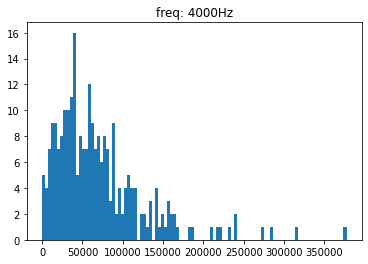

In [7]:
volt_threshold = 1 * 30000

for freq in ["500Hz", "1000Hz", "2000Hz", "4000Hz"]:
    
    df1 = pd.read_csv(f"../processed_dataset_with_smoothing/{freq}.csv")

    absolute_differences = []
    df1["label"] = 0
    df1["absolute_difference"] = 1

    for i in range(len(df1)):

        # Get the signal data
        signal_data = df1.loc[i, cols].values

        # Get the patient id
        patient_id = df1.loc[i, "Patient_ID"]
        patient_id = patient_id.replace(" ", "_")

        # decibel info
        dB = df1.loc[i, "Intensity"]

        if np.sum(signal_data)==0: 
            continue

        #print("Here")
        valley_value, peak_value = find_valley_and_peak(signal_data, patient_id, dB, freq, volt_threshold, True)
        absolute_differences.append(np.abs(valley_value - peak_value))

        df1.loc[i, "absolute_difference"] = np.abs(valley_value - peak_value)
    
    plt.hist(df1["absolute_difference"].values, bins=100)
    plt.title(f"freq: {freq}")
    plt.show()
    
    
    
    for i in range(len(df1)):    
        if np.abs(df1.loc[i, "absolute_difference"]) <= volt_threshold:
            df1.loc[i, "label"] = 1
            
    df1.to_csv(f"../processed_dataset_with_smoothing/labeled_data_{freq}.csv")

In [8]:
df1.head()

,Unnamed: 0,Patient_ID,Intensity,Ear,0,2,4,6,8,10,...,486,488,490,492,494,496,498,500,label,absolute_difference
0,0,A1_A1_ID-12,0dB,Left,-35604.103547,-50112.258521,-64245.763021,-77591.427218,-89750.838380,-100354.868193,...,-22986.329437,-19134.113934,-15430.966389,-11950.661429,-8721.244391,-5725.901767,-2908.990108,-186.968040,0,31178.493911
1,1,A1_A1_ID-12,20dB,Left,3185.200597,-29.152931,-2765.732657,-4605.387267,-5225.766429,-4437.218565,...,13505.539851,10684.021378,8053.571370,5728.405276,3758.377697,2125.854003,752.021698,-488.253266,1,22905.172515
2,2,A1_A1_ID-12,25 2dB,Left,13657.572020,15173.141254,16607.961961,17884.886301,18941.201309,19731.091018,...,-24570.007957,-22320.538241,-19709.578834,-16797.845732,-13636.586828,-10269.648628,-6736.887058,-3078.218076,0,109517.191689
3,3,A1_A1_ID-12,25dB,Left,3063.314908,2294.094029,1313.134540,-76.146924,-2038.535326,-4693.041291,...,24021.544965,21276.013805,18318.027621,15225.677117,12063.792969,8880.786630,5708.833309,2566.947686,0,72105.085960
4,4,A1_A1_ID-12,30dB,Left,2557.636509,6430.125279,9905.353372,12643.487924,14364.199534,14869.767338,...,-33967.362055,-32556.285618,-30980.846503,-29380.778959,-27860.532731,-26473.059910,-25215.786448,-24039.223705,0,116708.103982
